## Import dataset and split train and test sets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/Shareddrives/CIS520 Final Project/dataset/pre_processed/'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import os
import torch
from torch import nn, optim
from torchsummary import summary
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
### import the training and test sets

train = pd.read_csv(data_path + 'Train.csv')
X_train = train.drop(['DIABETE3','_TOTINDA'], axis = 1).values # the response variable and the redundent 'T_OTINDA' were dropped.
y_train = train['DIABETE3'].values.astype('int64')

test = pd.read_csv(data_path + 'Test.csv')
X_test = test.drop(['DIABETE3','_TOTINDA'], axis = 1).values # the response variable and the redundent 'T_OTINDA' were dropped.
y_test = test['DIABETE3'].values.astype('int64')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(135508, 22)
(135508,)
(33878, 22)
(33878,)


In [ ]:
### change the data sets to tensor to utilize GPU

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
# move device to CUDA if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
else:
   print("device = cpu")

## Helper functions and model definition

In [ ]:
### helper functions

## making confusion matrix
def conf_mat(yhat, y, threshold):
    yhat = yhat[:, 1]
    y_pred = np.zeros(yhat.shape)
    y_pred[np.where(yhat>=threshold)] = 1
    # Confusion Matrix
    print('\n Confusion matrix:')
    matrix = confusion_matrix(y,y_pred,labels=[1,0])
    precision = matrix[0,0]/(matrix[0,0] + matrix[1,0])
    recall = matrix[0,0]/(matrix[0,0] + matrix[0,1])
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    disp = ConfusionMatrixDisplay(matrix, display_labels=[1,0])
    fscore = 2*precision*recall/(precision + recall)
    print(f'accuracy: {acc}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f-score: {fscore}')
    disp.plot()
    plt.show()

    return acc, precision, recall, fscore

## plot precision-recall curve 
def pr_curve(yhat, y, classifier):
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y, yhat)
    # plot the roc curve for the model
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=classifier)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

## finding optimal threshold value
## code from https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
def opt_threshold(yhat, y, classifier):
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y, yhat)

    # convert to f1 score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    print('\n Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix])) 

    # plot the roc curve for the model
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=classifier)
    plt.plot(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

    y_pred = np.zeros(yhat.shape)
    y_pred[np.where(yhat>=thresholds[ix])] = 1
    # Confusion Matrix
    print('\n Confusion matrix:')
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred,labels=[1,0]), display_labels=[1,0])
    disp.plot()
    plt.show()

    return thresholds[ix], fscore[ix], precision[ix], recall[ix]


## split the training set into batches
def batch_split(X, y, batch_size = 128):
    total = len(X)
    batch_num = total // batch_size
    X_split = [None] * (batch_num + 1)
    y_split = [None] * (batch_num + 1)
    for i in range(batch_num + 1):
        if i != batch_num:
            X_split[i] = X[i*batch_size:(i+1)*batch_size].to(device)
            y_split[i] = y[i*batch_size:(i+1)*batch_size].to(device)
        else:
            X_split[i] = X[i*batch_size:].to(device)
            y_split[i] = y[i*batch_size:].to(device)
    return X_split, y_split

In [ ]:
### define model

class FCNN(nn.Module):
  def __init__(self, input_size = 22, hiddensize1 = 33, hiddensize2 = 44, hiddensize3 = 55):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.fc1 = nn.Linear(input_size, hiddensize1)
    self.fc2 = nn.Linear(hiddensize1, hiddensize2)
    self.fc3 = nn.Linear(hiddensize2, hiddensize3)
    self.fc = nn.Linear(hiddensize3, hiddensize3)
    self.fc4 = nn.Linear(hiddensize3, hiddensize2)
    self.fc5 = nn.Linear(hiddensize2, input_size)
    self.fc7 = nn.Linear(input_size, 11)
    self.fc8 = nn.Linear(11, 2)
    self.relu = nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.5)

  def forward(self, x):
    x = x.float()
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc(x))
    x = self.relu(self.fc(x))
    x = self.relu(self.fc(x))
    x = self.relu(self.fc4(x))
    x = self.relu(self.fc5(x))
    x = self.relu(self.fc7(x))
    x = self.fc8(x)

    return x

# # model summary

fcnn_example = FCNN()
fcnn_example.to(device)
summary(fcnn_example, (1,22))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 33]             759
              ReLU-2                [-1, 1, 33]               0
            Linear-3                [-1, 1, 44]           1,496
              ReLU-4                [-1, 1, 44]               0
            Linear-5                [-1, 1, 55]           2,475
              ReLU-6                [-1, 1, 55]               0
            Linear-7                [-1, 1, 55]           3,080
              ReLU-8                [-1, 1, 55]               0
            Linear-9                [-1, 1, 55]           3,080
             ReLU-10                [-1, 1, 55]               0
           Linear-11                [-1, 1, 55]           3,080
             ReLU-12                [-1, 1, 55]               0
           Linear-13                [-1, 1, 44]           2,464
             ReLU-14                [-1

## Hyper-parameter tuning

In [ ]:
# defining hyperparameters space.
epoch = 15
batch_sizes = [32, 128, 512]
learning_rates = [0.01, 0.001]
weights = [3.5, 3.8, 4.15, 4.5]
neural_nets = []
train_losses = []
parameters = []
preds_train = []
preds_test = []

batch_size: 32; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 2361.0058

--------------------
epoch: 6, loss: 2293.4838

--------------------
epoch: 9, loss: 2279.1959

--------------------
epoch: 12, loss: 2271.4032

--------------------
epoch: 15, loss: 2266.1264


 Best Threshold=0.415015, F-Score=0.472, Precision=0.367, Recall=0.658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


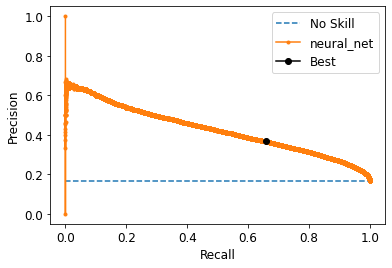


 Confusion matrix:


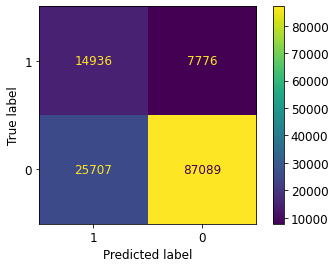


 Confusion matrix:
accuracy: 0.7551508353503749
precision: 0.36950234367208534
recall: 0.6525184924269108
f-score: 0.4718242597898758


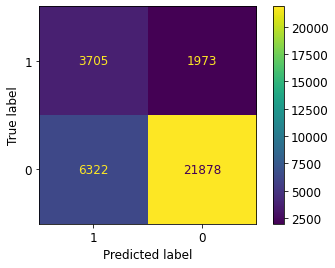

batch_size: 32; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 2700.3199

--------------------
epoch: 6, loss: 2324.9307

--------------------
epoch: 9, loss: 2305.5007

--------------------
epoch: 12, loss: 2296.3253

--------------------
epoch: 15, loss: 2290.3207


 Best Threshold=0.426665, F-Score=0.472, Precision=0.368, Recall=0.659


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


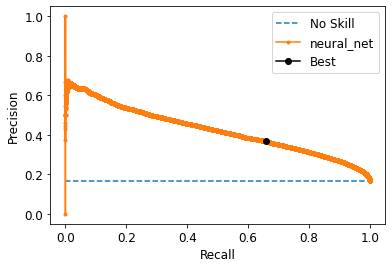


 Confusion matrix:


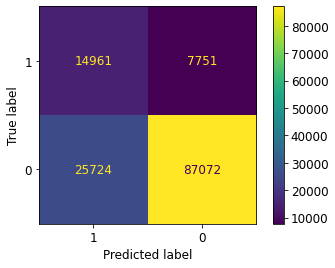


 Confusion matrix:
accuracy: 0.7548556585394651
precision: 0.3691342034472452
recall: 0.6525184924269108
f-score: 0.47152402163538015


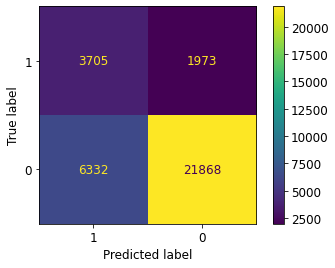

batch_size: 32; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 2888.4882

--------------------
epoch: 6, loss: 2343.7148

--------------------
epoch: 9, loss: 2322.4011

--------------------
epoch: 12, loss: 2312.5962

--------------------
epoch: 15, loss: 2307.0795


 Best Threshold=0.469292, F-Score=0.472, Precision=0.375, Recall=0.638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


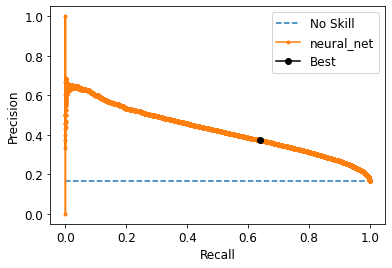


 Confusion matrix:


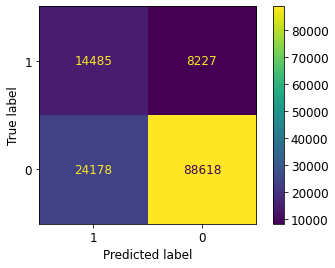


 Confusion matrix:
accuracy: 0.762795914752937
precision: 0.37654450261780104
recall: 0.6333215921098978
f-score: 0.4722878907276071


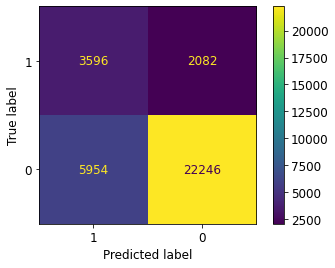

batch_size: 32; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 2535.3818

--------------------
epoch: 6, loss: 2344.1569

--------------------
epoch: 9, loss: 2327.1030

--------------------
epoch: 12, loss: 2318.6236

--------------------
epoch: 15, loss: 2313.3607


 Best Threshold=0.495470, F-Score=0.472, Precision=0.373, Recall=0.642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


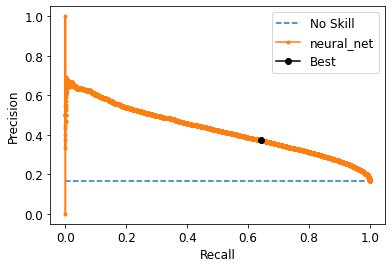


 Confusion matrix:


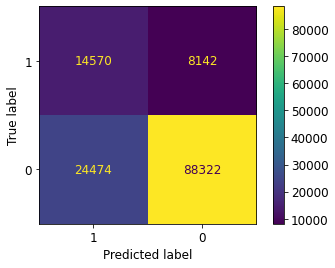


 Confusion matrix:
accuracy: 0.7627073617096641
precision: 0.37712084938065993
recall: 0.6380767876012681
f-score: 0.4740595354923127


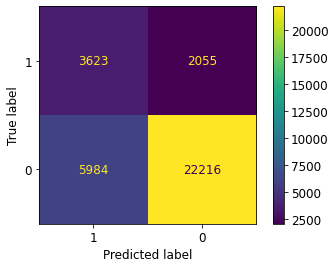

batch_size: 32; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 2248.7944

--------------------
epoch: 6, loss: 2236.7960

--------------------
epoch: 9, loss: 2231.3981

--------------------
epoch: 12, loss: 2227.9264

--------------------
epoch: 15, loss: 2225.2324


 Best Threshold=0.484656, F-Score=0.478, Precision=0.375, Recall=0.657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


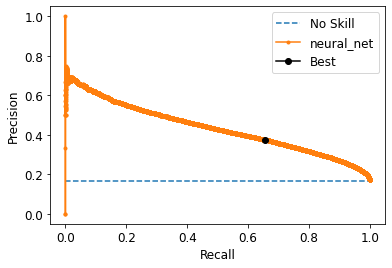


 Confusion matrix:


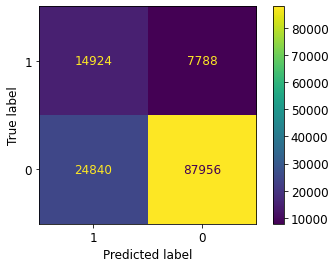


 Confusion matrix:
accuracy: 0.7602278764980224
precision: 0.37521690313361233
recall: 0.6474110602324762
f-score: 0.47508885298869136


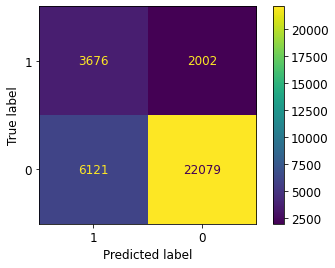

batch_size: 32; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 2267.4873

--------------------
epoch: 6, loss: 2254.6632

--------------------
epoch: 9, loss: 2249.8593

--------------------
epoch: 12, loss: 2247.0660

--------------------
epoch: 15, loss: 2245.1445


 Best Threshold=0.519120, F-Score=0.478, Precision=0.381, Recall=0.640


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


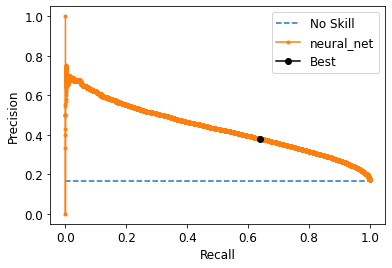


 Confusion matrix:


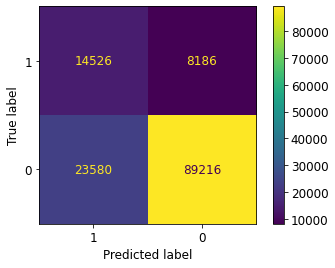


 Confusion matrix:
accuracy: 0.7685223448845858
precision: 0.3842533162173727
recall: 0.6326171187037689
f-score: 0.4781046186609875


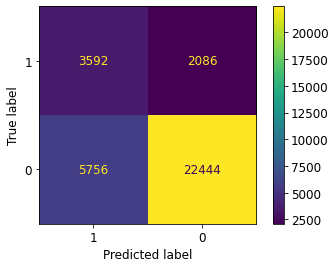

batch_size: 32; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 2295.4337

--------------------
epoch: 6, loss: 2276.0801

--------------------
epoch: 9, loss: 2268.1313

--------------------
epoch: 12, loss: 2263.4390

--------------------
epoch: 15, loss: 2260.1951


 Best Threshold=0.535257, F-Score=0.479, Precision=0.387, Recall=0.627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


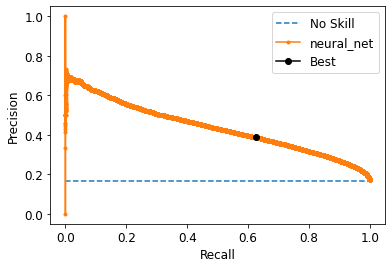


 Confusion matrix:


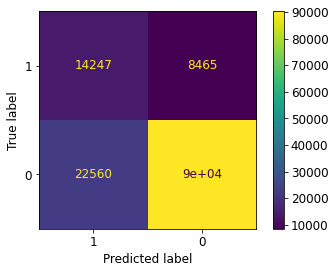


 Confusion matrix:
accuracy: 0.7722710903831395
precision: 0.3873465324632231
recall: 0.6167664670658682
f-score: 0.4758475439907602


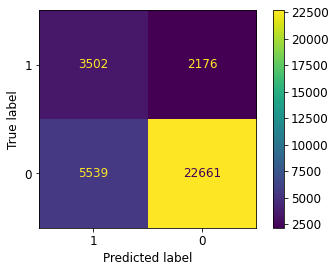

batch_size: 32; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 2297.7660

--------------------
epoch: 6, loss: 2282.4530

--------------------
epoch: 9, loss: 2275.6140

--------------------
epoch: 12, loss: 2271.7540

--------------------
epoch: 15, loss: 2269.1084


 Best Threshold=0.558740, F-Score=0.478, Precision=0.386, Recall=0.629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


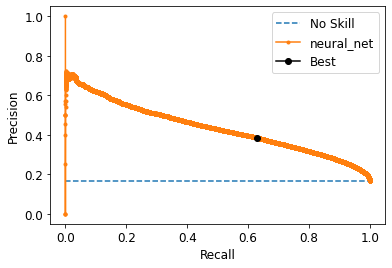


 Confusion matrix:


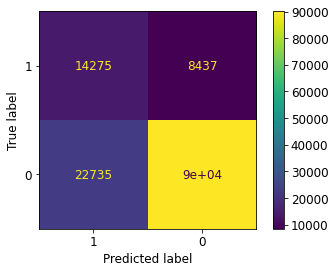


 Confusion matrix:
accuracy: 0.7704114764744082
precision: 0.3850952068286277
recall: 0.6197604790419161
f-score: 0.4750269978401728


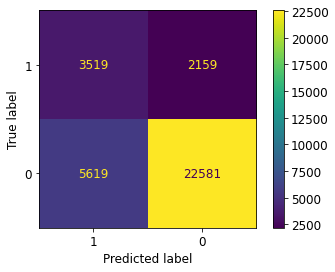

batch_size: 32; learning rate: 0.001; optimizer: SGD; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 2850.1925

--------------------
epoch: 6, loss: 2849.4907

--------------------
epoch: 9, loss: 2848.2124

--------------------
epoch: 12, loss: 2845.5789

--------------------
epoch: 15, loss: 2838.7770


 Best Threshold=0.400603, F-Score=0.386, Precision=0.288, Recall=0.583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


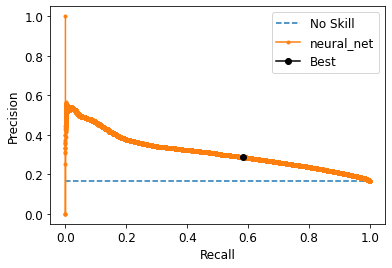


 Confusion matrix:


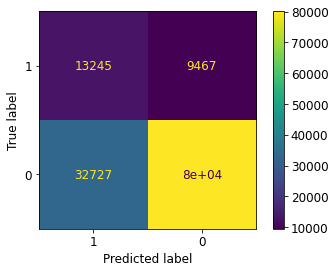


 Confusion matrix:
accuracy: 0.6907137375287797
precision: 0.2911954062989386
recall: 0.5894681225783727
f-score: 0.3898206382483112


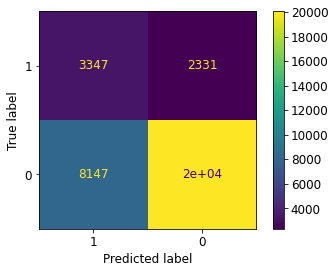

batch_size: 32; learning rate: 0.001; optimizer: SGD; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 2880.1645

--------------------
epoch: 6, loss: 2880.0454

--------------------
epoch: 9, loss: 2879.9356

--------------------
epoch: 12, loss: 2879.7967

--------------------
epoch: 15, loss: 2879.5856


 Best Threshold=0.418932, F-Score=0.364, Precision=0.255, Recall=0.634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


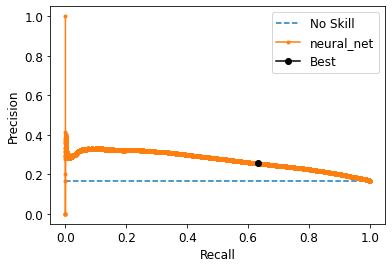


 Confusion matrix:


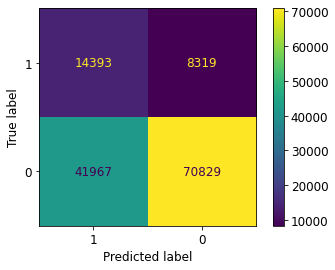


 Confusion matrix:
accuracy: 0.6352500147588406
precision: 0.26161753158683704
recall: 0.6454737583656217
f-score: 0.37232691623914255


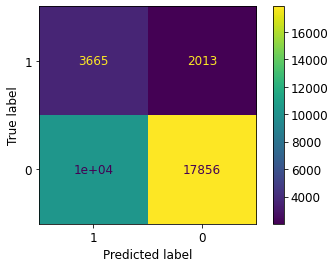

batch_size: 32; learning rate: 0.001; optimizer: SGD; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 2904.0789



KeyboardInterrupt: ignored

In [ ]:
# performing grid search on the hyperparameter space. 

for batch in batch_sizes:
  for lr in learning_rates:
    for optim_name in ['SGD', 'Adagrad']:
      for weight in weights:
        w = torch.tensor([1, weight])
        w = w.to(device)
        criterion = nn.CrossEntropyLoss(weight = w)
        param_set = (batch, lr, optim_name, w)
        X_train_batch, y_train_batch = batch_split(X_train, y_train, batch_size = batch)
        fcnn = FCNN()
        fcnn.to(device) 
        if optim_name == 'SGD':
            optimizer = optim.SGD(fcnn.parameters(), lr=lr)
        elif optim_name == 'Adagrad':
            optimizer = optim.Adagrad(fcnn.parameters(), lr=lr)
        print(f'batch_size: {batch}; learning rate: {lr}; optimizer: {optim_name}; class_weight: {w}')

        # training iterations
        for ep in range(epoch):
            running_loss = 0
            for i in range(len(X_train_batch)):
                # data and label
                data = X_train_batch[i]
                label = y_train_batch[i]
                # zero gradient
                optimizer.zero_grad()
                # forward path
                y_pred = fcnn(data)
                loss = criterion(y_pred, label)
                running_loss += loss.item()
                # backpropagating
                loss.backward()
                # optimizes the weights
                optimizer.step()
                # if (i+1) % 30 == 0:
                #     print(f'batch: {i + 1}, loss: {loss}')
      
            if (ep + 1)%3 == 0:
              print('--------------------')
              print(f'epoch: {ep+1}, loss: {running_loss:.4f}')
              print()
            
            if ep == epoch - 1:
                train_losses.append(running_loss)
        
        # prediction result on the training set
        m = nn.Softmax(dim=1)
        y_pred_train_sm = m(fcnn(X_train))
        y_pred_train_sm = y_pred_train_sm.cpu().detach().numpy()
        y_train_cpu = y_train.cpu().detach().numpy()
        pred_set_train = opt_threshold(y_pred_train_sm, y_train_cpu,'neural_net')

        threshold, opt_f1_threshold, opt_precison_threshold, opt_recall_threshold = pred_set_train


        ## prediction result on the test set
        y_pred_test_sm = m(fcnn(X_test))
        y_pred_test_sm = y_pred_test_sm.cpu().detach().numpy()
        y_test_cpu = y_test.cpu().detach().numpy()
        pred_set_test = conf_mat(y_pred_test_sm, y_test_cpu, threshold)

        neural_nets.append(fcnn)
        parameters.append(param_set)
        preds_train.append(pred_set_train)
        preds_test.append(pred_set_test)

batch_size: 128; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 716.4322

--------------------
epoch: 6, loss: 680.7898

--------------------
epoch: 9, loss: 586.3058

--------------------
epoch: 12, loss: 575.9638

--------------------
epoch: 15, loss: 572.3777

--------------------
epoch: 18, loss: 570.4525

--------------------
epoch: 21, loss: 569.1955

--------------------
epoch: 24, loss: 568.2837

--------------------
epoch: 27, loss: 567.5011

--------------------
epoch: 30, loss: 566.9104


 Best Threshold=0.474075, F-Score=0.475, Precision=0.376, Recall=0.646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


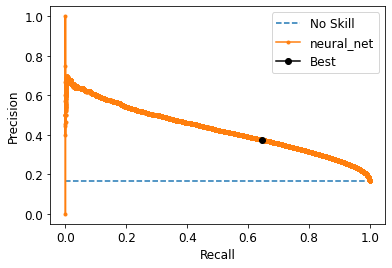


 Confusion matrix:


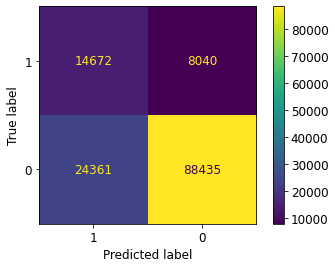


 Confusion matrix:
accuracy: 0.7623826672176633
precision: 0.3767920216081446
recall: 0.638781261007397
f-score: 0.47399372713016213


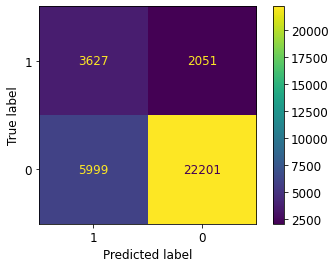

batch_size: 128; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 723.2144

--------------------
epoch: 6, loss: 720.5079

--------------------
epoch: 9, loss: 600.9637

--------------------
epoch: 12, loss: 581.7032

--------------------
epoch: 15, loss: 577.2348

--------------------
epoch: 18, loss: 574.9143

--------------------
epoch: 21, loss: 573.4812

--------------------
epoch: 24, loss: 572.4567

--------------------
epoch: 27, loss: 571.6677

--------------------
epoch: 30, loss: 571.0438


 Best Threshold=0.522414, F-Score=0.475, Precision=0.383, Recall=0.626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


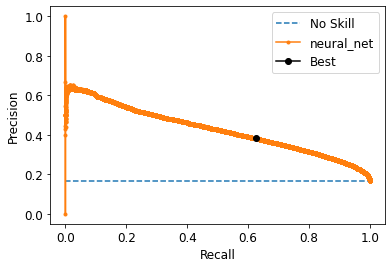


 Confusion matrix:


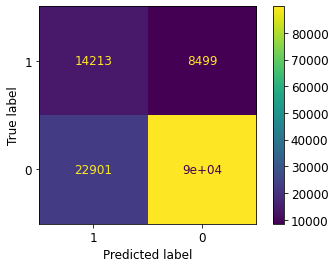


 Confusion matrix:
accuracy: 0.7704409941554992
precision: 0.38518761623454767
recall: 0.6201127157449806
f-score: 0.47520075578649024


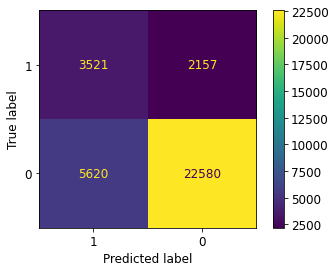

batch_size: 128; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 728.8768

--------------------
epoch: 6, loss: 728.5705

--------------------
epoch: 9, loss: 725.3742

--------------------
epoch: 12, loss: 602.7797

--------------------
epoch: 15, loss: 585.1640

--------------------
epoch: 18, loss: 580.5157

--------------------
epoch: 21, loss: 578.1102

--------------------
epoch: 24, loss: 576.6962

--------------------
epoch: 27, loss: 575.7289

--------------------
epoch: 30, loss: 574.9874


 Best Threshold=0.539348, F-Score=0.475, Precision=0.381, Recall=0.629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


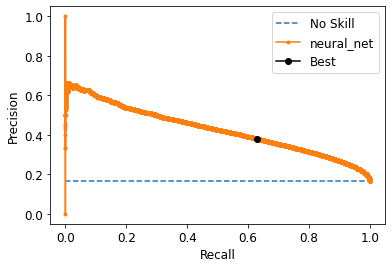


 Confusion matrix:


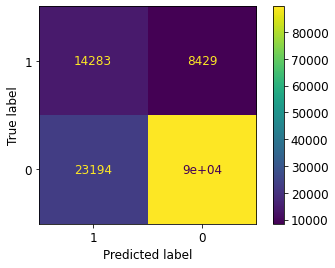


 Confusion matrix:
accuracy: 0.7693488399551331
precision: 0.3845654993514916
recall: 0.6266290947516732
f-score: 0.4766242464835901


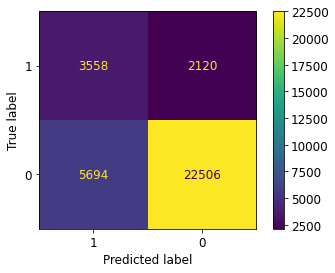

batch_size: 128; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 731.4639

--------------------
epoch: 6, loss: 713.2648

--------------------
epoch: 9, loss: 595.7402

--------------------
epoch: 12, loss: 584.9649

--------------------
epoch: 15, loss: 581.2559

--------------------
epoch: 18, loss: 579.3056

--------------------
epoch: 21, loss: 578.0903

--------------------
epoch: 24, loss: 577.1776

--------------------
epoch: 27, loss: 576.4787

--------------------
epoch: 30, loss: 575.9081


 Best Threshold=0.554802, F-Score=0.474, Precision=0.379, Recall=0.631


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


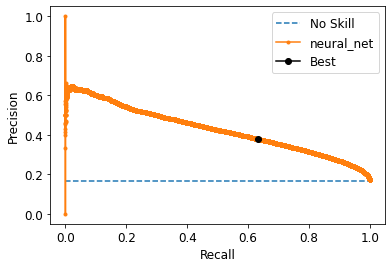


 Confusion matrix:


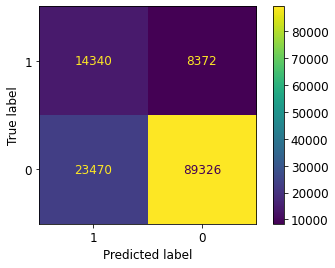


 Confusion matrix:
accuracy: 0.7675777790896747
precision: 0.3823907455012853
recall: 0.6287425149700598
f-score: 0.4755561475955774


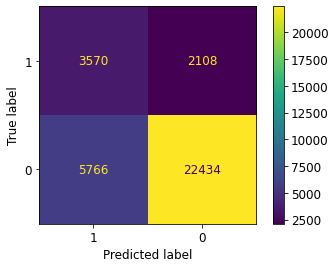

batch_size: 128; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 566.0664

--------------------
epoch: 6, loss: 562.7932

--------------------
epoch: 9, loss: 561.3310

--------------------
epoch: 12, loss: 560.3515

--------------------
epoch: 15, loss: 559.6545

--------------------
epoch: 18, loss: 559.0865

--------------------
epoch: 21, loss: 558.6446

--------------------
epoch: 24, loss: 558.2645

--------------------
epoch: 27, loss: 557.9086

--------------------
epoch: 30, loss: 557.6152


 Best Threshold=0.495828, F-Score=0.479, Precision=0.379, Recall=0.652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


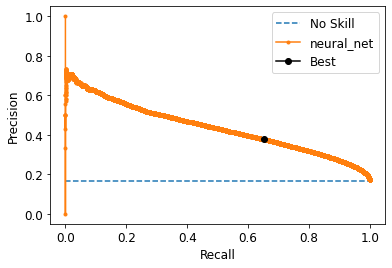


 Confusion matrix:


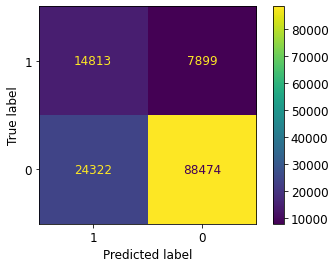


 Confusion matrix:
accuracy: 0.7636519275045752
precision: 0.3789626857914978
recall: 0.6421275096865093
f-score: 0.4766324596378848


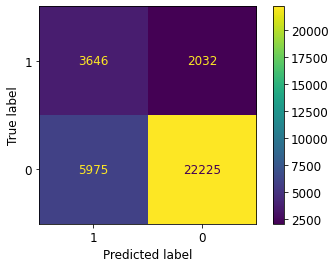

batch_size: 128; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 569.0680

--------------------
epoch: 6, loss: 566.0424

--------------------
epoch: 9, loss: 564.6996

--------------------
epoch: 12, loss: 563.9162

--------------------
epoch: 15, loss: 563.3483

--------------------
epoch: 18, loss: 562.8968

--------------------
epoch: 21, loss: 562.5212

--------------------
epoch: 24, loss: 562.1935

--------------------
epoch: 27, loss: 561.8694

--------------------
epoch: 30, loss: 561.5754


 Best Threshold=0.523018, F-Score=0.478, Precision=0.381, Recall=0.643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


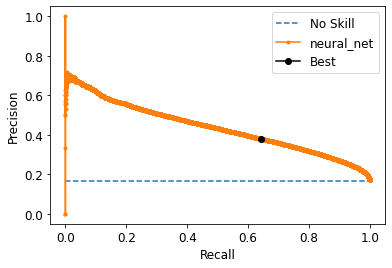


 Confusion matrix:


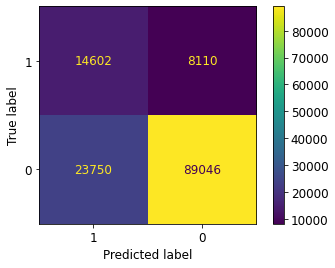


 Confusion matrix:
accuracy: 0.7665446602514906
precision: 0.38231881000105494
recall: 0.6382529059528003
f-score: 0.4781948934485716


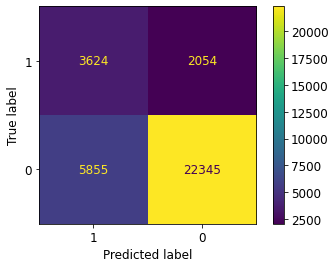

batch_size: 128; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 573.1989

--------------------
epoch: 6, loss: 569.6154

--------------------
epoch: 9, loss: 568.1087

--------------------
epoch: 12, loss: 567.1444

--------------------
epoch: 15, loss: 566.4733

--------------------
epoch: 18, loss: 565.9574

--------------------
epoch: 21, loss: 565.5176

--------------------
epoch: 24, loss: 565.1608

--------------------
epoch: 27, loss: 564.8258

--------------------
epoch: 30, loss: 564.5439


 Best Threshold=0.552994, F-Score=0.478, Precision=0.385, Recall=0.630


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


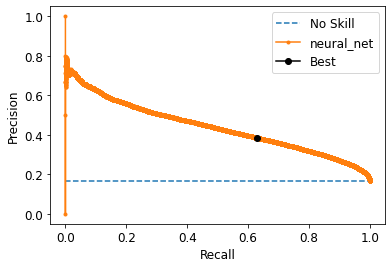


 Confusion matrix:


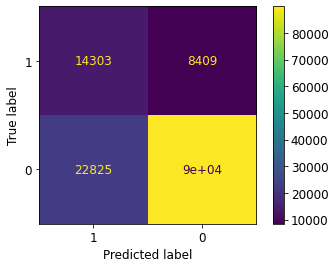


 Confusion matrix:
accuracy: 0.771798807485684
precision: 0.3875561397743455
recall: 0.6231067277210285
f-score: 0.47788208279867633


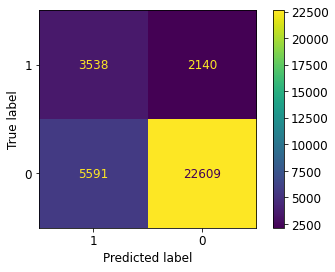

batch_size: 128; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 575.0713

--------------------
epoch: 6, loss: 571.8039

--------------------
epoch: 9, loss: 570.3009

--------------------
epoch: 12, loss: 569.3653

--------------------
epoch: 15, loss: 568.6986

--------------------
epoch: 18, loss: 568.1679

--------------------
epoch: 21, loss: 567.7007

--------------------
epoch: 24, loss: 567.3214

--------------------
epoch: 27, loss: 566.9907

--------------------
epoch: 30, loss: 566.6702


 Best Threshold=0.588641, F-Score=0.479, Precision=0.391, Recall=0.616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


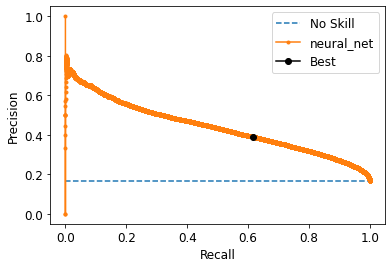


 Confusion matrix:


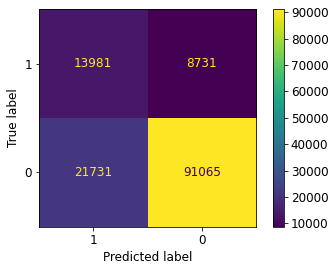


 Confusion matrix:
accuracy: 0.7767577779089675
precision: 0.39254360962261997
recall: 0.6063754843254667
f-score: 0.4765727732022977


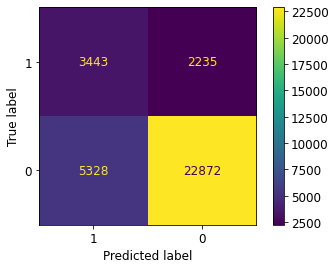

batch_size: 512; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 179.5981

--------------------
epoch: 6, loss: 179.5828

--------------------
epoch: 9, loss: 179.5661

--------------------
epoch: 12, loss: 179.5454

--------------------
epoch: 15, loss: 179.5172

--------------------
epoch: 18, loss: 179.4776

--------------------
epoch: 21, loss: 179.4161

--------------------
epoch: 24, loss: 179.3069

--------------------
epoch: 27, loss: 179.1032

--------------------
epoch: 30, loss: 178.5482


 Best Threshold=0.410806, F-Score=0.398, Precision=0.286, Recall=0.655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


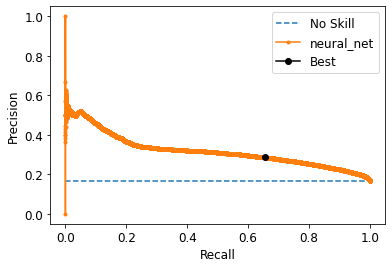


 Confusion matrix:


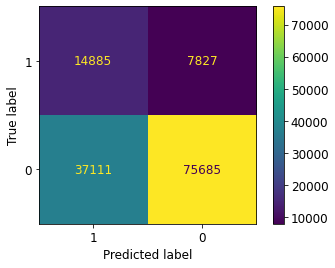


 Confusion matrix:
accuracy: 0.6690772772890962
precision: 0.286420134331815
recall: 0.653399084184572
f-score: 0.3982609629112769


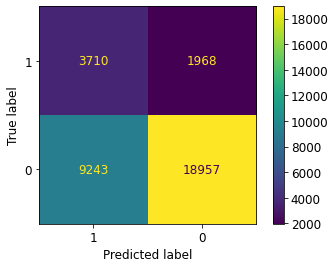

batch_size: 512; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 181.2035

--------------------
epoch: 6, loss: 181.0603

--------------------
epoch: 9, loss: 180.7554

--------------------
epoch: 12, loss: 179.8055

--------------------
epoch: 15, loss: 173.5537

--------------------
epoch: 18, loss: 157.0860

--------------------
epoch: 21, loss: 148.5806

--------------------
epoch: 24, loss: 145.6616

--------------------
epoch: 27, loss: 144.7383

--------------------
epoch: 30, loss: 144.1883


 Best Threshold=0.583173, F-Score=0.470, Precision=0.376, Recall=0.624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


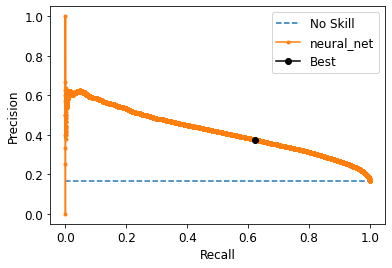


 Confusion matrix:


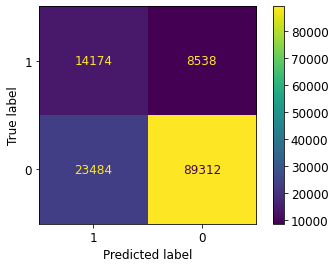


 Confusion matrix:
accuracy: 0.7653049176456698
precision: 0.37807102242248686
recall: 0.6206410707995773
f-score: 0.46989799319954667


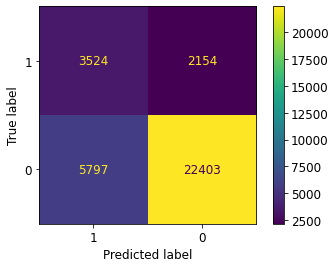

batch_size: 512; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 182.5742

--------------------
epoch: 6, loss: 182.5701

--------------------
epoch: 9, loss: 182.5665

--------------------
epoch: 12, loss: 182.5616

--------------------
epoch: 15, loss: 182.5554

--------------------
epoch: 18, loss: 182.5475

--------------------
epoch: 21, loss: 182.5386

--------------------
epoch: 24, loss: 182.5286

--------------------
epoch: 27, loss: 182.5160

--------------------
epoch: 30, loss: 182.4996


 Best Threshold=0.453765, F-Score=0.411, Precision=0.303, Recall=0.637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


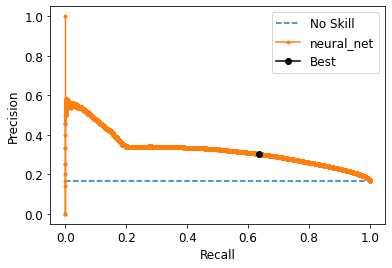


 Confusion matrix:


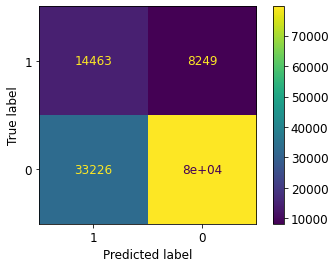


 Confusion matrix:
accuracy: 0.6956727079520633
precision: 0.3047546788062721
recall: 0.6366678407890102
f-score: 0.41220068415051303


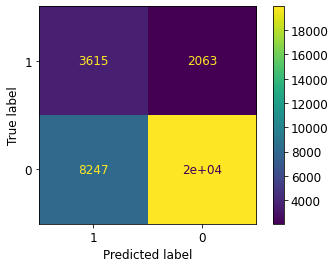

batch_size: 512; learning rate: 0.01; optimizer: SGD; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 183.3188

--------------------
epoch: 6, loss: 183.2981

--------------------
epoch: 9, loss: 183.2769

--------------------
epoch: 12, loss: 183.2468

--------------------
epoch: 15, loss: 183.2061

--------------------
epoch: 18, loss: 183.1444

--------------------
epoch: 21, loss: 183.0379

--------------------
epoch: 24, loss: 182.8254

--------------------
epoch: 27, loss: 182.3602

--------------------
epoch: 30, loss: 180.9596


 Best Threshold=0.467821, F-Score=0.399, Precision=0.282, Recall=0.676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


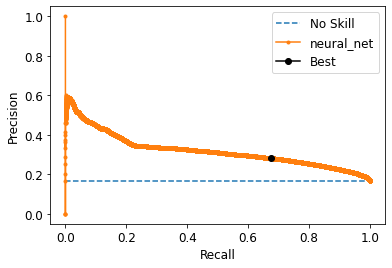


 Confusion matrix:


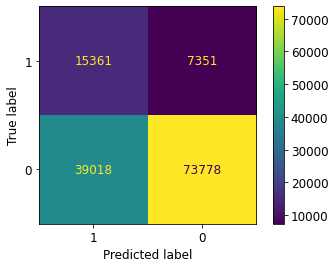


 Confusion matrix:
accuracy: 0.6610779857134423
precision: 0.2855136733185514
recall: 0.6803451919690031
f-score: 0.4022282382340691


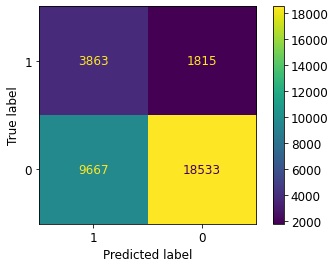

batch_size: 512; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.5000], device='cuda:0')
--------------------
epoch: 3, loss: 142.7185

--------------------
epoch: 6, loss: 141.5118

--------------------
epoch: 9, loss: 140.9920

--------------------
epoch: 12, loss: 140.6775

--------------------
epoch: 15, loss: 140.4532

--------------------
epoch: 18, loss: 140.2746

--------------------
epoch: 21, loss: 140.1406

--------------------
epoch: 24, loss: 140.0278

--------------------
epoch: 27, loss: 139.9345

--------------------
epoch: 30, loss: 139.8465


 Best Threshold=0.553632, F-Score=0.478, Precision=0.395, Recall=0.606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


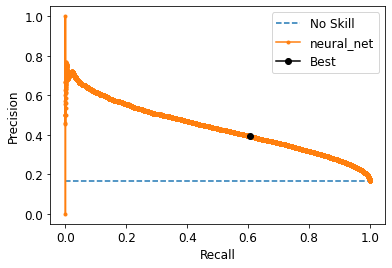


 Confusion matrix:


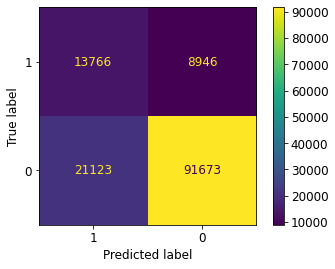


 Confusion matrix:
accuracy: 0.7789125686286086
precision: 0.39474907063197023
recall: 0.5984501585065164
f-score: 0.4757104857902842


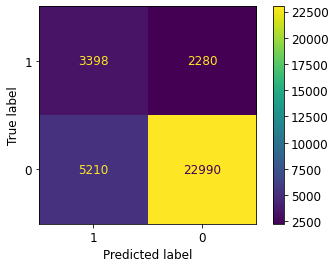

batch_size: 512; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 3.8000], device='cuda:0')
--------------------
epoch: 3, loss: 144.0089

--------------------
epoch: 6, loss: 142.3584

--------------------
epoch: 9, loss: 141.8131

--------------------
epoch: 12, loss: 141.5052

--------------------
epoch: 15, loss: 141.3051

--------------------
epoch: 18, loss: 141.1621

--------------------
epoch: 21, loss: 141.0500

--------------------
epoch: 24, loss: 140.9652

--------------------
epoch: 27, loss: 140.8867

--------------------
epoch: 30, loss: 140.8192


 Best Threshold=0.528034, F-Score=0.479, Precision=0.380, Recall=0.649


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


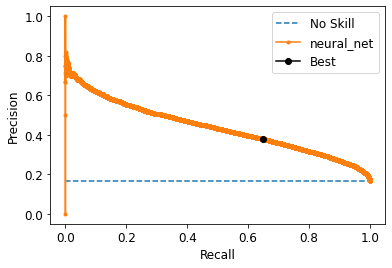


 Confusion matrix:


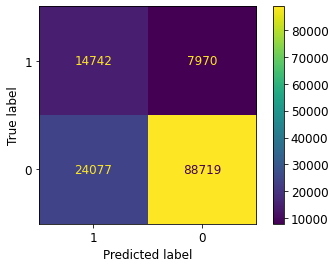


 Confusion matrix:
accuracy: 0.7648031170671232
precision: 0.38020506382088304
recall: 0.6400140894681225
f-score: 0.4770280913625624


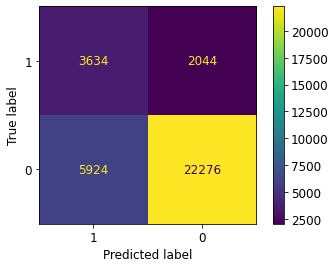

batch_size: 512; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.1500], device='cuda:0')
--------------------
epoch: 3, loss: 145.3070

--------------------
epoch: 6, loss: 143.8504

--------------------
epoch: 9, loss: 143.1405

--------------------
epoch: 12, loss: 142.6856

--------------------
epoch: 15, loss: 142.3904

--------------------
epoch: 18, loss: 142.1777

--------------------
epoch: 21, loss: 142.0198

--------------------
epoch: 24, loss: 141.8929

--------------------
epoch: 27, loss: 141.7856

--------------------
epoch: 30, loss: 141.6937


 Best Threshold=0.567783, F-Score=0.479, Precision=0.383, Recall=0.639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


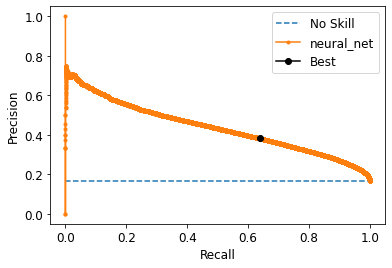


 Confusion matrix:


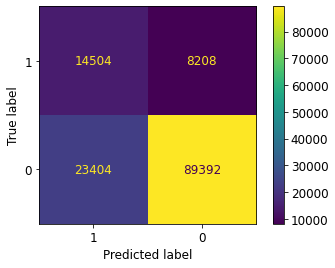


 Confusion matrix:
accuracy: 0.7671054961922191
precision: 0.382089552238806
recall: 0.6312081718915111
f-score: 0.47602603267366184


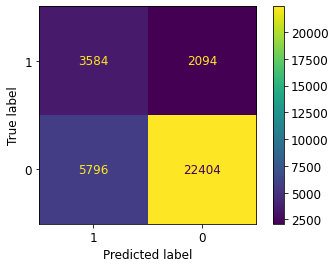

batch_size: 512; learning rate: 0.01; optimizer: Adagrad; class_weight: tensor([1.0000, 4.5000], device='cuda:0')
--------------------
epoch: 3, loss: 145.1394

--------------------
epoch: 6, loss: 143.9173

--------------------
epoch: 9, loss: 143.3310

--------------------
epoch: 12, loss: 142.9720

--------------------
epoch: 15, loss: 142.7221

--------------------
epoch: 18, loss: 142.5360

--------------------
epoch: 21, loss: 142.3863

--------------------
epoch: 24, loss: 142.2708

--------------------
epoch: 27, loss: 142.1766

--------------------
epoch: 30, loss: 142.0909


 Best Threshold=0.596759, F-Score=0.478, Precision=0.386, Recall=0.628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


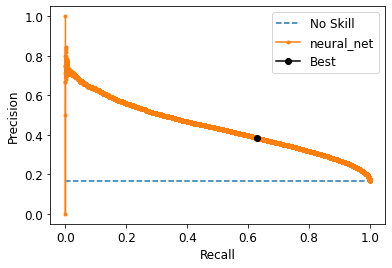


 Confusion matrix:


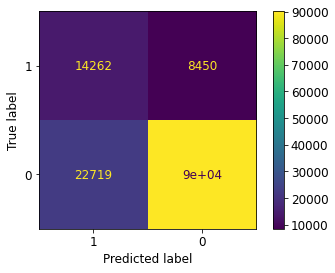


 Confusion matrix:
accuracy: 0.7712379715449554
precision: 0.3860536735591729
recall: 0.6181754138781261
f-score: 0.4752877454299256


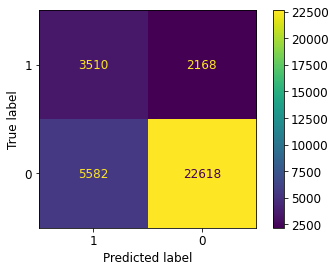

In [ ]:
# since the last iteration was interrupted, 
# run another iteration for hyper-parameter tuning, 
# using larger batch_size and more epochs to avoid runtime runout.

for batch in [128, 512]:
  for lr in [0.01]:
    for optim_name in ['SGD', 'Adagrad']:
      for weight in weights:
        w = torch.tensor([1, weight])
        w = w.to(device)
        criterion = nn.CrossEntropyLoss(weight = w)
        param_set = (batch, lr, optim_name, w)
        X_train_batch, y_train_batch = batch_split(X_train, y_train, batch_size = batch)
        fcnn = FCNN()
        fcnn.to(device) 
        if optim_name == 'SGD':
            optimizer = optim.SGD(fcnn.parameters(), lr=lr)
        elif optim_name == 'Adagrad':
            optimizer = optim.Adagrad(fcnn.parameters(), lr=lr)
        print(f'batch_size: {batch}; learning rate: {lr}; optimizer: {optim_name}; class_weight: {w}')

        # training iterations
        for ep in range(30):
            running_loss = 0
            for i in range(len(X_train_batch)):
                # data and label
                data = X_train_batch[i]
                label = y_train_batch[i]
                # zero gradient
                optimizer.zero_grad()
                # forward path
                y_pred = fcnn(data)
                loss = criterion(y_pred, label)
                running_loss += loss.item()
                # backpropagating
                loss.backward()
                # optimizes the weights
                optimizer.step()
                # if (i+1) % 30 == 0:
                #     print(f'batch: {i + 1}, loss: {loss}')
      
            if (ep + 1)%3 == 0:
              print('--------------------')
              print(f'epoch: {ep+1}, loss: {running_loss:.4f}')
              print()
            
            if ep == epoch - 1:
                train_losses.append(running_loss)
        
        # prediction result on the training set
        m = nn.Softmax(dim=1)
        y_pred_train_sm = m(fcnn(X_train))
        y_pred_train_sm = y_pred_train_sm.cpu().detach().numpy()
        y_train_cpu = y_train.cpu().detach().numpy()
        pred_set_train = opt_threshold(y_pred_train_sm, y_train_cpu,'neural_net')

        threshold, opt_f1_threshold, opt_precison_threshold, opt_recall_threshold = pred_set_train


          ## prediction result on the test set
        y_pred_test_sm = m(fcnn(X_test))
        y_pred_test_sm = y_pred_test_sm.cpu().detach().numpy()
        y_test_cpu = y_test.cpu().detach().numpy()
        pred_set_test = conf_mat(y_pred_test_sm, y_test_cpu, threshold)

        neural_nets.append(fcnn)
        parameters.append(param_set)
        preds_train.append(pred_set_train)
        preds_test.append(pred_set_test)